In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms as TR
import trimesh
from src.utilities.operators import mean_2d_3ch
from src.utilities.util import (
    make_faces, 
    list_to_grid, 
    grid_to_list,
)

from src.config import get_parser
from src.render.mesh_points_renderer import MeshPointsRenderer

In [3]:
device = torch.device('cuda')
scale_factor = 4

loaded = torch.load('./data/patch_64_64.pth')
vertices = loaded['vertices']
vertices = F.interpolate(vertices, scale_factor=scale_factor, 
    mode='bilinear', align_corners=True).to(device)
print(vertices.shape)
faces = make_faces(vertices.size(-1), vertices.size(-1))
faces = torch.tensor(faces[None]).to(device)
print(faces.shape)

torch.Size([1, 3, 256, 256])
torch.Size([1, 130050, 3])


In [4]:
config = get_parser().parse_args(args=[])  
config.viewpoint_distance = 1.05
config.fast_image_size = 256

renderer = MeshPointsRenderer(config).to(device)
renderer

MeshPointsRenderer()

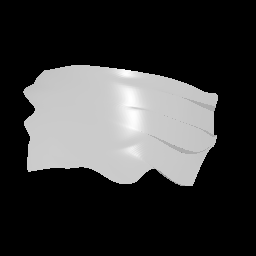

In [5]:
imgs = renderer(vertices, faces)
img = TR.ToPILImage()(imgs[0])
img

In [13]:
model = nn.Sequential(
    nn.Conv2d(3, 128, 3, stride=1, padding=1,
        padding_mode='reflect'),
    nn.LeakyReLU(negative_slope=0.2),
    nn.Conv2d(128, 128, 3, stride=1, padding=1,
        padding_mode='reflect'),
    nn.LeakyReLU(negative_slope=0.2),
    nn.Conv2d(128, 3, 3, stride=1, padding=1,
        padding_mode='reflect'),
).to(device)
res = model(vertices)
res.shape

torch.Size([1, 3, 256, 256])

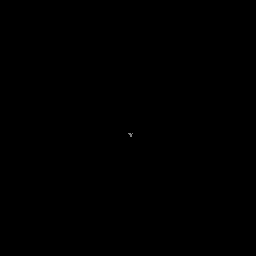

In [14]:
imgs = renderer(res, faces)
img = TR.ToPILImage()(imgs[0])
img

tensor(2.4656e-05, device='cuda:0', grad_fn=<MseLossBackward>)


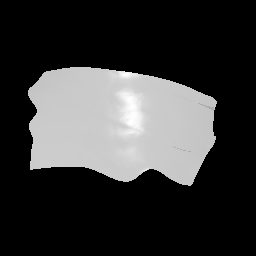

In [28]:
mean2d3ch =  mean_2d_3ch(33).to(device)
r = res + (mean2d3ch(vertices) - mean2d3ch(res))
print(F.mse_loss(r, vertices))
imgs = renderer(r, faces)
img = TR.ToPILImage()(imgs[0])
img

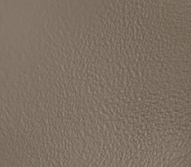

In [32]:
from PIL import Image

img =Image.open('./data/skin.png')
img

mean: 0.44780805706977844, std: 0.02203664742410183


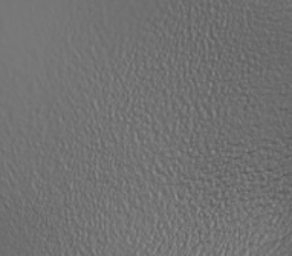

In [55]:
transform = TR.Compose([
    TR.Resize(config.fast_image_size),
    TR.Grayscale(),
    TR.ToTensor(),   
])
img_t = transform(img)
mean, std = img_t.mean().item(), img_t.std().item()
print(f'mean: {mean}, std: {std}')
transform = TR.Compose([
    TR.Resize(config.fast_image_size),
    TR.Grayscale(),
    TR.ToTensor(),
    TR.Normalize((mean), (std)),   
])
img_t = transform(img)
TR.ToPILImage()((img_t * std) + mean)